In [1]:
import matplotlib.pyplot as plt

import jax
from njx.base import funcutils
import njx.models.mainen_sejnowski as model
from njx.models.mainen_sejnowski import NeuronParameters, ChannelParameter

mode.NeuronParameters



In [2]:

import jax.numpy as np


In [3]:

soma_parameters = NeuronParameters(
    Cm = 0.75, # uF/cm^2 * cm^2 = uF
    Ra = 150.0 , # ohm.cm / cm * 10e-3 = kOhm
    na = ChannelParameter(E=50, g=20), # mS/cm^2 * cm^2 = mS
    ca = ChannelParameter(E=140, g=0.3), # mS/cm^2 * cm^2 = mS
    kv = ChannelParameter(E=-90, g=3.0), # mS/cm^2 * cm^2 = mS
    km = ChannelParameter(E=-90, g=200.0), # mS/cm^2 * cm^2 = mS
    kca = ChannelParameter(E=-90, g=3.0), # mS/cm^2 * cm^2 =  mS 
    leak = ChannelParameter(E=-70, g=0.3), # frustum_surface * 1/30000.0), # mS/cm^2 * cm^2 = mS
    ca_infty = 0.1, # uM
    tau_ca = 200.0, # ms
)

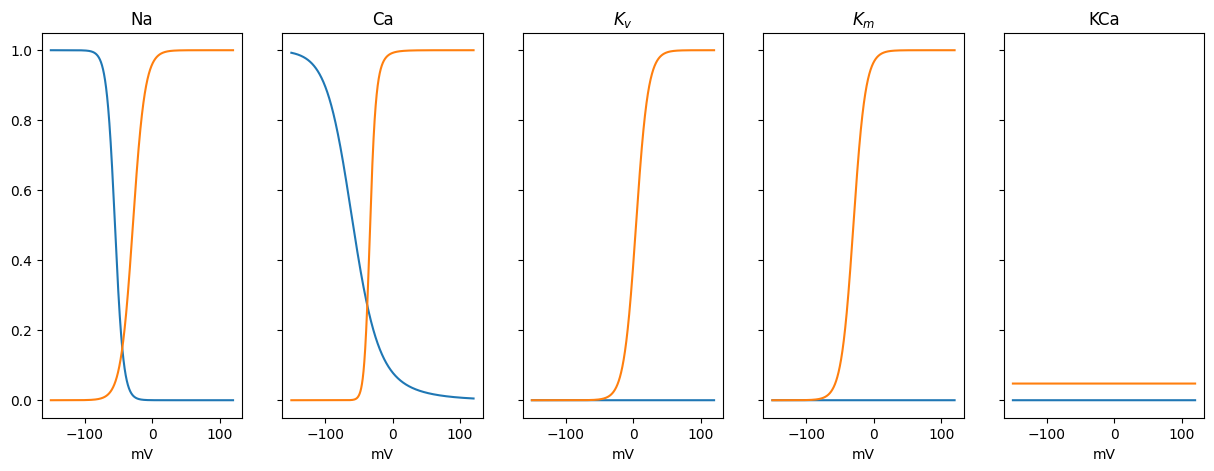

In [4]:
import jax.numpy as jp

fig, ax = plt.subplots(1,5, sharey=True, figsize=(15, 5))

vs = jp.arange(-150, 120, 0.1)

equilibrium = [
    ("Na", model.na_equilibrium(vs)),
    ("Ca", model.ca_equilibrium(vs)),
    ("$K_v$", model.kv_equilibrium(vs)),
    ("$K_m$", model.km_equilibrium(vs)),
    ("KCa", model.kca_equilibrium(vs, jp.ones_like(vs)*0.1))
]

for i, (title, eq) in enumerate(equilibrium):
    ax[i].plot(vs, eq.h, label="h")
    ax[i].plot(vs, eq.m, label="m")
    ax[i].set_xlabel("mV")
    ax[i].set_title(title)



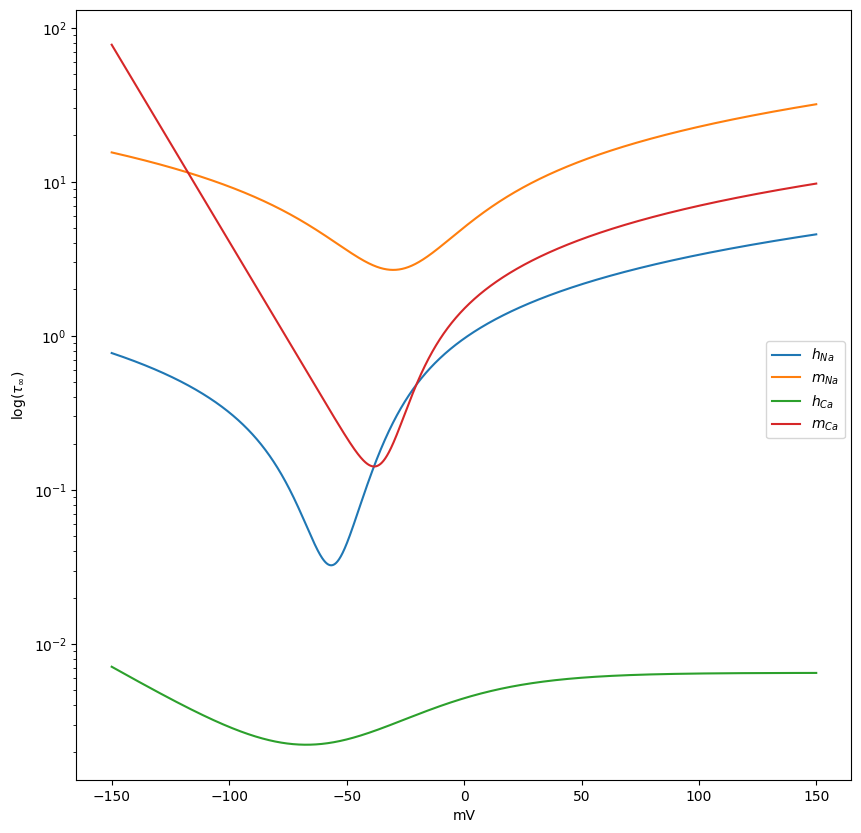

In [5]:
import jax.numpy as jp

fig, ax = plt.subplots(1,1, figsize=(10, 10), sharey=True)

vs = jp.arange(-150, 150, 0.1)

timeconstant = [
    ("Na", model.na_time_constant(vs)),
    ("Ca", model.ca_time_constant(vs)),
]

for i, (title, eq) in enumerate(timeconstant):
    ax.semilogy(vs, 1/eq.h, label=f"$h_{{{title}}}$")
    ax.semilogy(vs, 1/eq.m, label=f"$m_{{{title}}}$")
    ax.set_xlabel("mV")
    ax.set_ylabel("$\log(\\tau_{\infty})$")

# legend on right center, without box
fig.legend(loc="center right", bbox_to_anchor=(.9, 0.5), ncol=1)

In [6]:
def initial_membrane_channel_state(v, ca_i):
    return model.MembraneChannels(
        na=model.na_equilibrium(v),
        ca=model.ca_equilibrium(v),
        kv=model.kv_equilibrium(v),
        km=model.km_equilibrium(v),
        kca=model.kca_equilibrium(v, ca_i)
    )

initial_state = model.NeuronState(
    v = soma_parameters.leak.E,
    ca_i = soma_parameters.ca_infty,
    channels = initial_membrane_channel_state(soma_parameters.leak.E, soma_parameters.ca_infty)
)


def soma_dynamics(p: model.NeuronParameters):
    def dynamics(state: model.NeuronState, I):
        return model.NeuronState(
            v=(1/p.Cm) * (-model.I_total(state.v, state.channels, p) + I),
            ca_i=0, # model.ca_i_dynamics(state.ca_i, state, p),
            channels=model.membrane_channel_dynamics(state.v, state.ca_i, state.channels, p)
        )
    return dynamics

In [7]:
from jaxsnn.base import explicit


def projection(x, u):
    return x


def output(x, u):
    return x

dynamics = soma_dynamics(soma_parameters)
equation = explicit.ExplicitConstrainedCDE(
    explicit_terms=dynamics, projection=projection, output=output
)

In [8]:
import numpy as onp

T = 30000
dt = 0.001
step_fn = explicit.classic_rk4_cde(equation, dt)

stim = onp.zeros(T)
stim[7000:14000] = 200  # add a square pulse
ts = onp.arange(0, int(dt * T), dt)
integrator = funcutils.controlled_trajectory(step_fn, stim)
integrator = jax.jit(integrator)

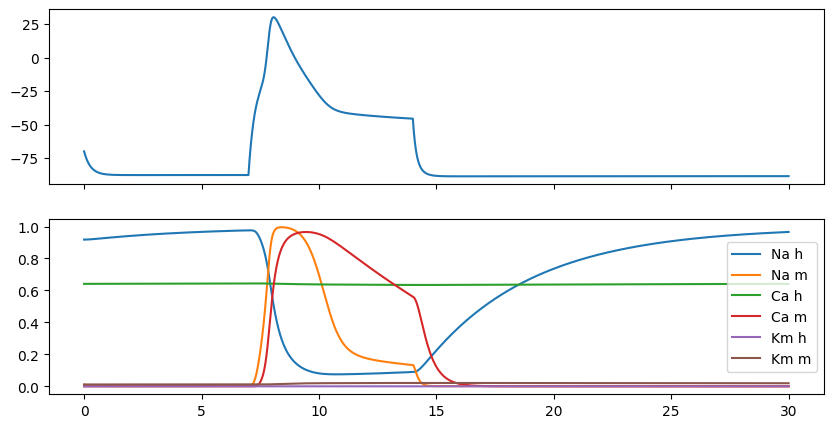

In [9]:


fig, ax = plt.subplots(2,1, figsize=(10, 5), sharex=True)
jax.config.update("jax_enable_x64", True)
ax[0].plot(ts[:T], integrator(initial_state)[1].v[:T], label="V")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.na.h[:T], label="Na h")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.na.m[:T], label="Na m")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.ca.h[:T], label="Ca h")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.ca.m[:T], label="Ca m")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.km.h[:T], label="Km h")
ax[1].plot(ts[:T], integrator(initial_state)[1].channels.km.m[:T], label="Km m")
plt.legend()

# plt.plot(integrator(initial_state)[1].ca_i[:150])

In [10]:
import numpy as np

def plot_soma(s: model.NeuronState, stimulus):
    fig, ax = plt.subplots(3, figsize=(10, 5), sharex=True)
    ts = np.arange(0, int(dt * T), dt)

    ax[0].set_ylabel("Voltage (mV)")
    ax[1].set_ylabel("Current ($\mu A$)")
    ax[2].set_ylabel("x(t)")
    ax[0].plot(ts, s.v)
    ax[1].plot(ts, stimulus)
    ax[1].set_ybound(0, 5.5)
    ax[2].plot(ts, s.channels.na.m, label="m")
    ax[2].plot(ts, s.channels.na.h, label="h")
    ax[2].legend(loc="upper right", frameon=False)
    # ax[3].plot(ts, s.m**3 * s.h, label="m")
    # ax[4].plot(ts, s.n**4, label="h")

    ax[2].set_xlabel("Time (ms)")

    # these constants are extracted from the specific
    ax[0].hlines(-35, ts[0], ts[-1], color="grey", linestyles="-.")
    ax[0].hlines(25, ts[0], ts[-1], color="grey", linestyles="-.")
    ax[0].hlines(-62, ts[0], ts[-1], color="grey", linestyles="-.")

    return fig, ax

(<Figure size 1000x500 with 3 Axes>,
 array([<Axes: ylabel='Voltage (mV)'>, <Axes: ylabel='Current ($\\mu A$)'>,
        <Axes: xlabel='Time (ms)', ylabel='x(t)'>], dtype=object))

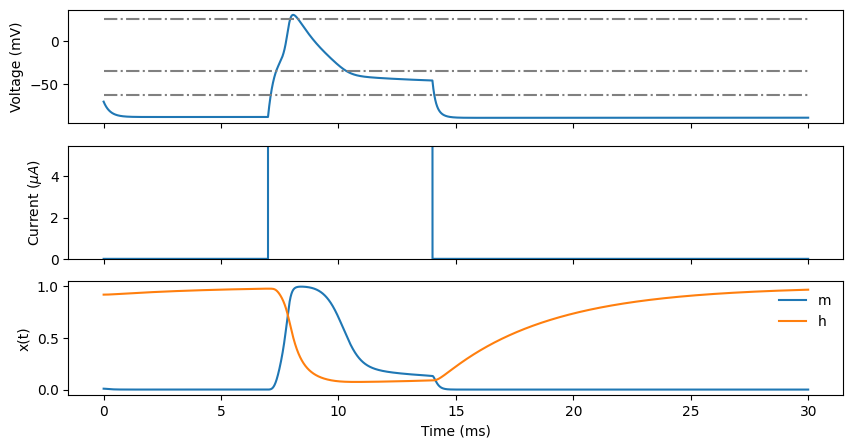

In [11]:
plot_soma(integrator(initial_state)[1], stim)